# Geo Experimentation via Time Based Regression in PyMC

## Prepare Notebook

In [8]:
import arviz as az
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import pymc as pm
import pymc.sampling_jax
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from itertools import chain


plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read Data

In [6]:
data_df = pd.read_csv("../data/zipcodes_data.csv", parse_dates=["date"])

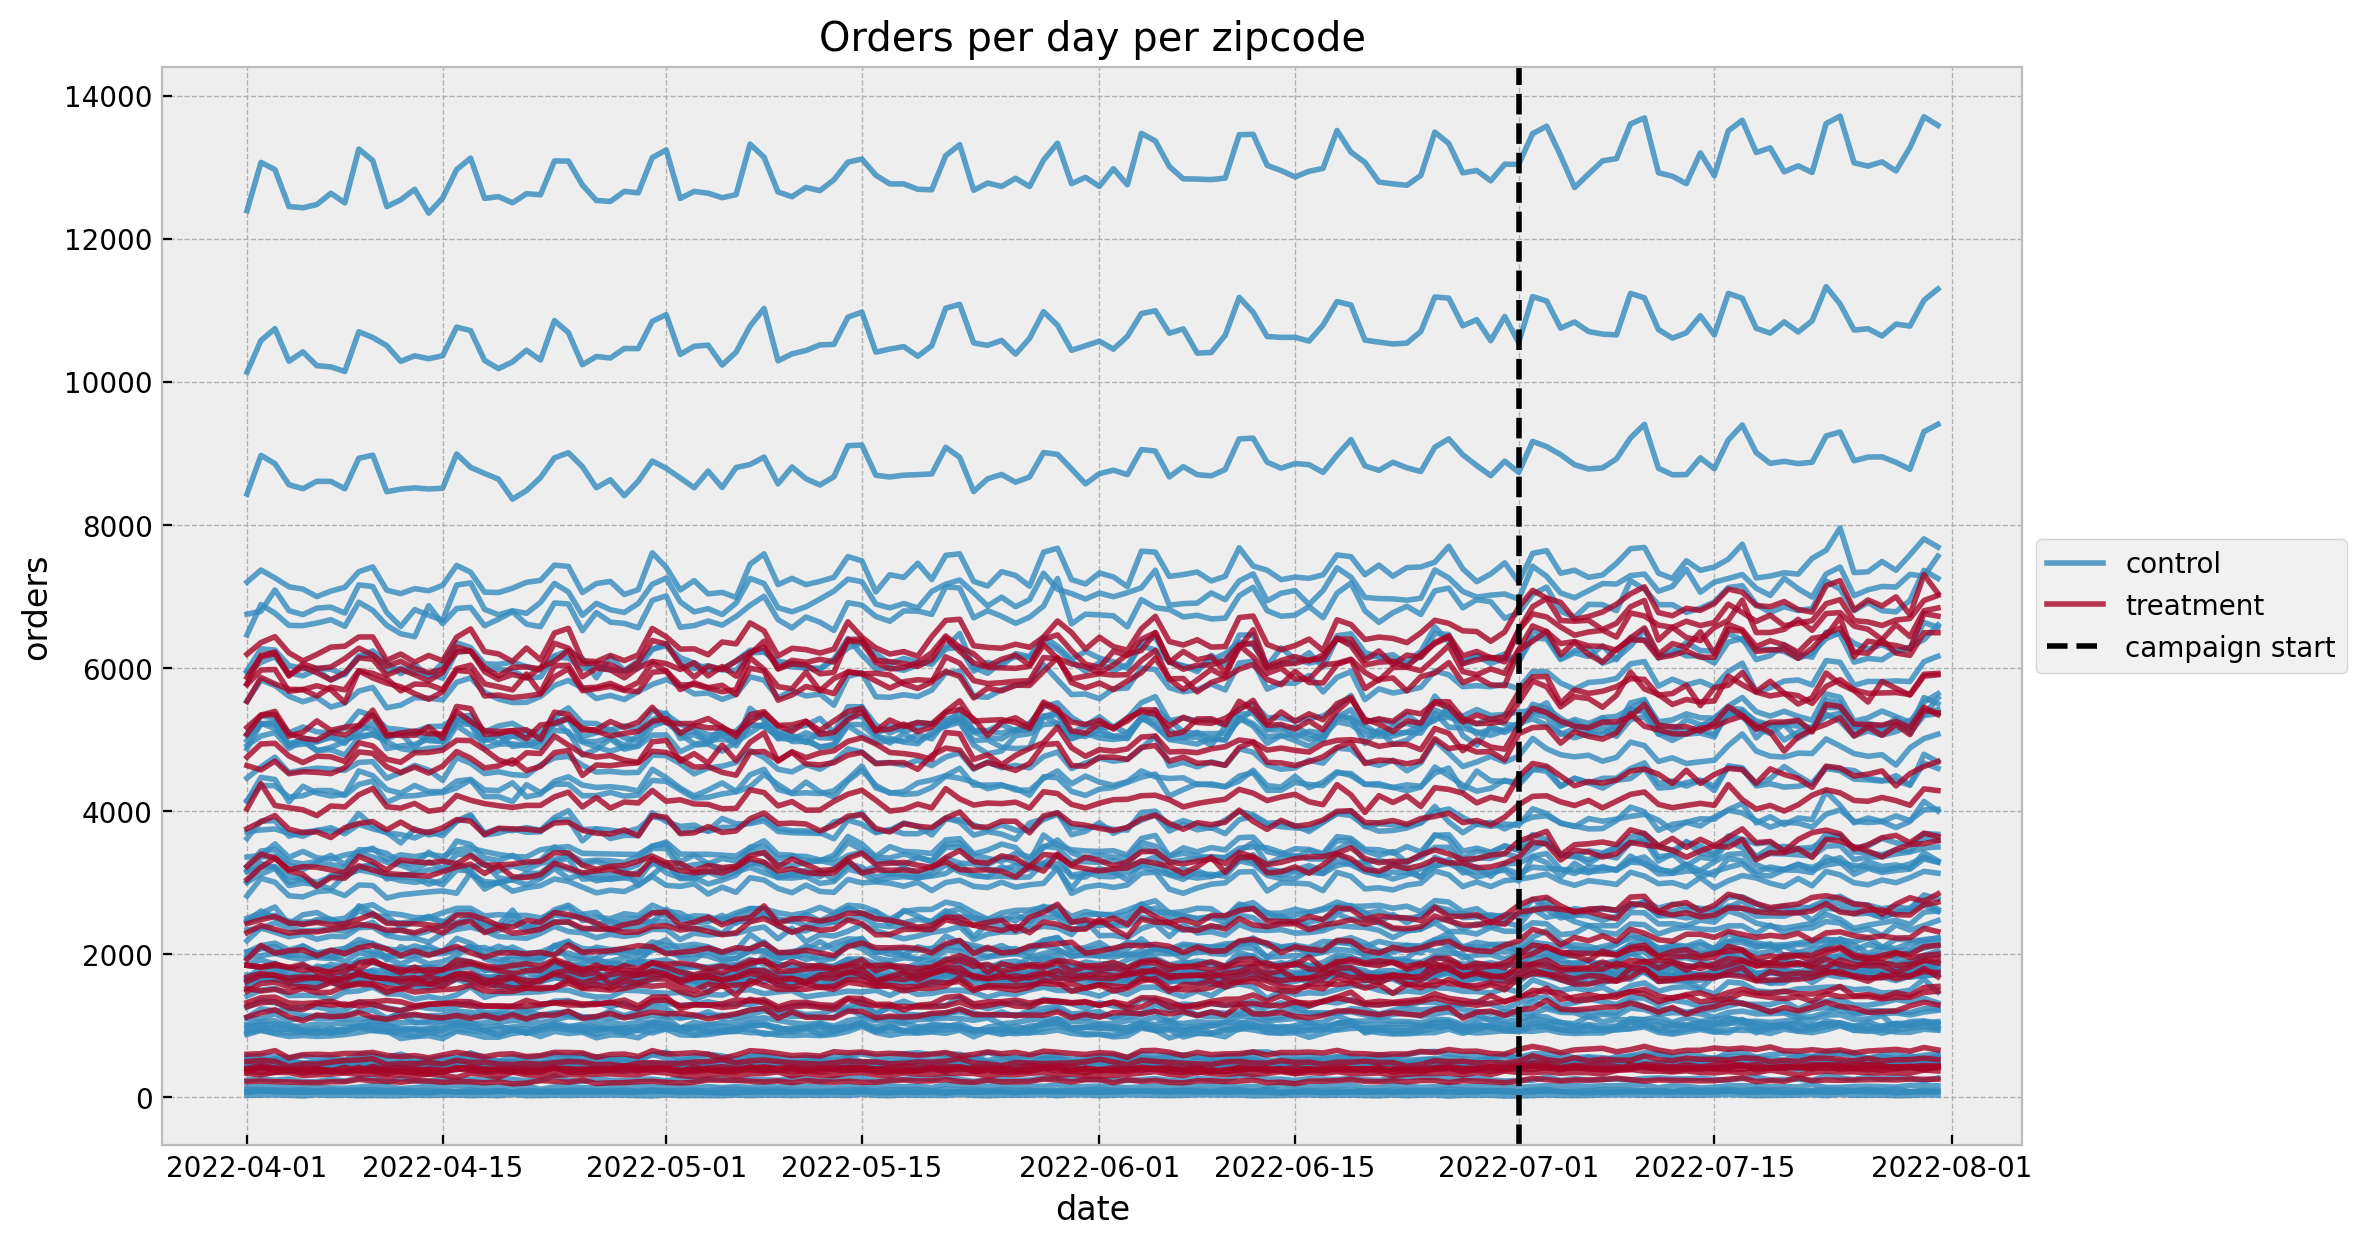

In [9]:
start_campaign = datetime(2022, 7, 1)

fig, ax = plt.subplots(figsize=(12, 7))

for i, variant in enumerate(["control", "treatment"]):
    for j, (_, df) in enumerate(
        data_df.query("variant == @variant").groupby("zipcode")
    ):
        label = variant if j == 0 else None
        sns.lineplot(
            x="date", y="orders", data=df, color=f"C{i}", alpha=0.8, label=label, ax=ax
        )

ax.axvline(x=start_campaign, color="black", linestyle="--", label="campaign start")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Orders per day per zipcode", xlabel="date", ylabel="orders");

## Prepare Data

In [26]:
agg_data_df = (
    data_df
    .groupby(["date", "is_campaign", "variant"], as_index=False)
    .agg({"orders": np.sum})
)

data_train = (
    agg_data_df
    .query("~ is_campaign")
    .pivot(index="date", columns="variant", values="orders")
    .reset_index()
)

data_test = (
    agg_data_df
    .query("is_campaign")
    .pivot(index="date", columns="variant", values="orders")
    .reset_index()
)

In [30]:
date_train = data_train["date"].to_numpy()
y_control_train = data_train["control"].to_numpy()
y_treatment_train = data_train["treatment"].to_numpy()

date_test = data_test["date"].to_numpy()
y_control_test = data_test["control"].to_numpy()
y_treatment_test = data_test["treatment"].to_numpy()

n_train = data_train.shape[0]
n_test = data_test.shape[0]
n = n_train + n_test
idx_train = range(n_train)
idx_test = range(n_train, n)

# weighted linear regression: https://discourse.pymc.io/t/how-to-add-weights-to-data-in-bayesian-linear-regression/8362
w_train = np.linspace(start=0.8, stop=1, num=n_train)
w_train = np.ones(shape=n_train)
w_test = np.ones(shape=n_test)

In [36]:
scaler_control = MinMaxScaler()
scaler_treatment = MinMaxScaler()

scaler_control.fit(X=y_control_train[..., None])
scaler_treatment.fit(X=y_treatment_train[..., None])

y_control_train_scaled = scaler_control.transform(X=y_control_train[..., None]).flatten()
y_treatment_train_scaled = scaler_treatment.transform(X=y_treatment_train[..., None]).flatten()

y_control_test_scaled = scaler_control.transform(X=y_control_test[..., None]).flatten()
y_treatment_test_scaled = scaler_treatment.transform(X=y_treatment_test[..., None]).flatten()

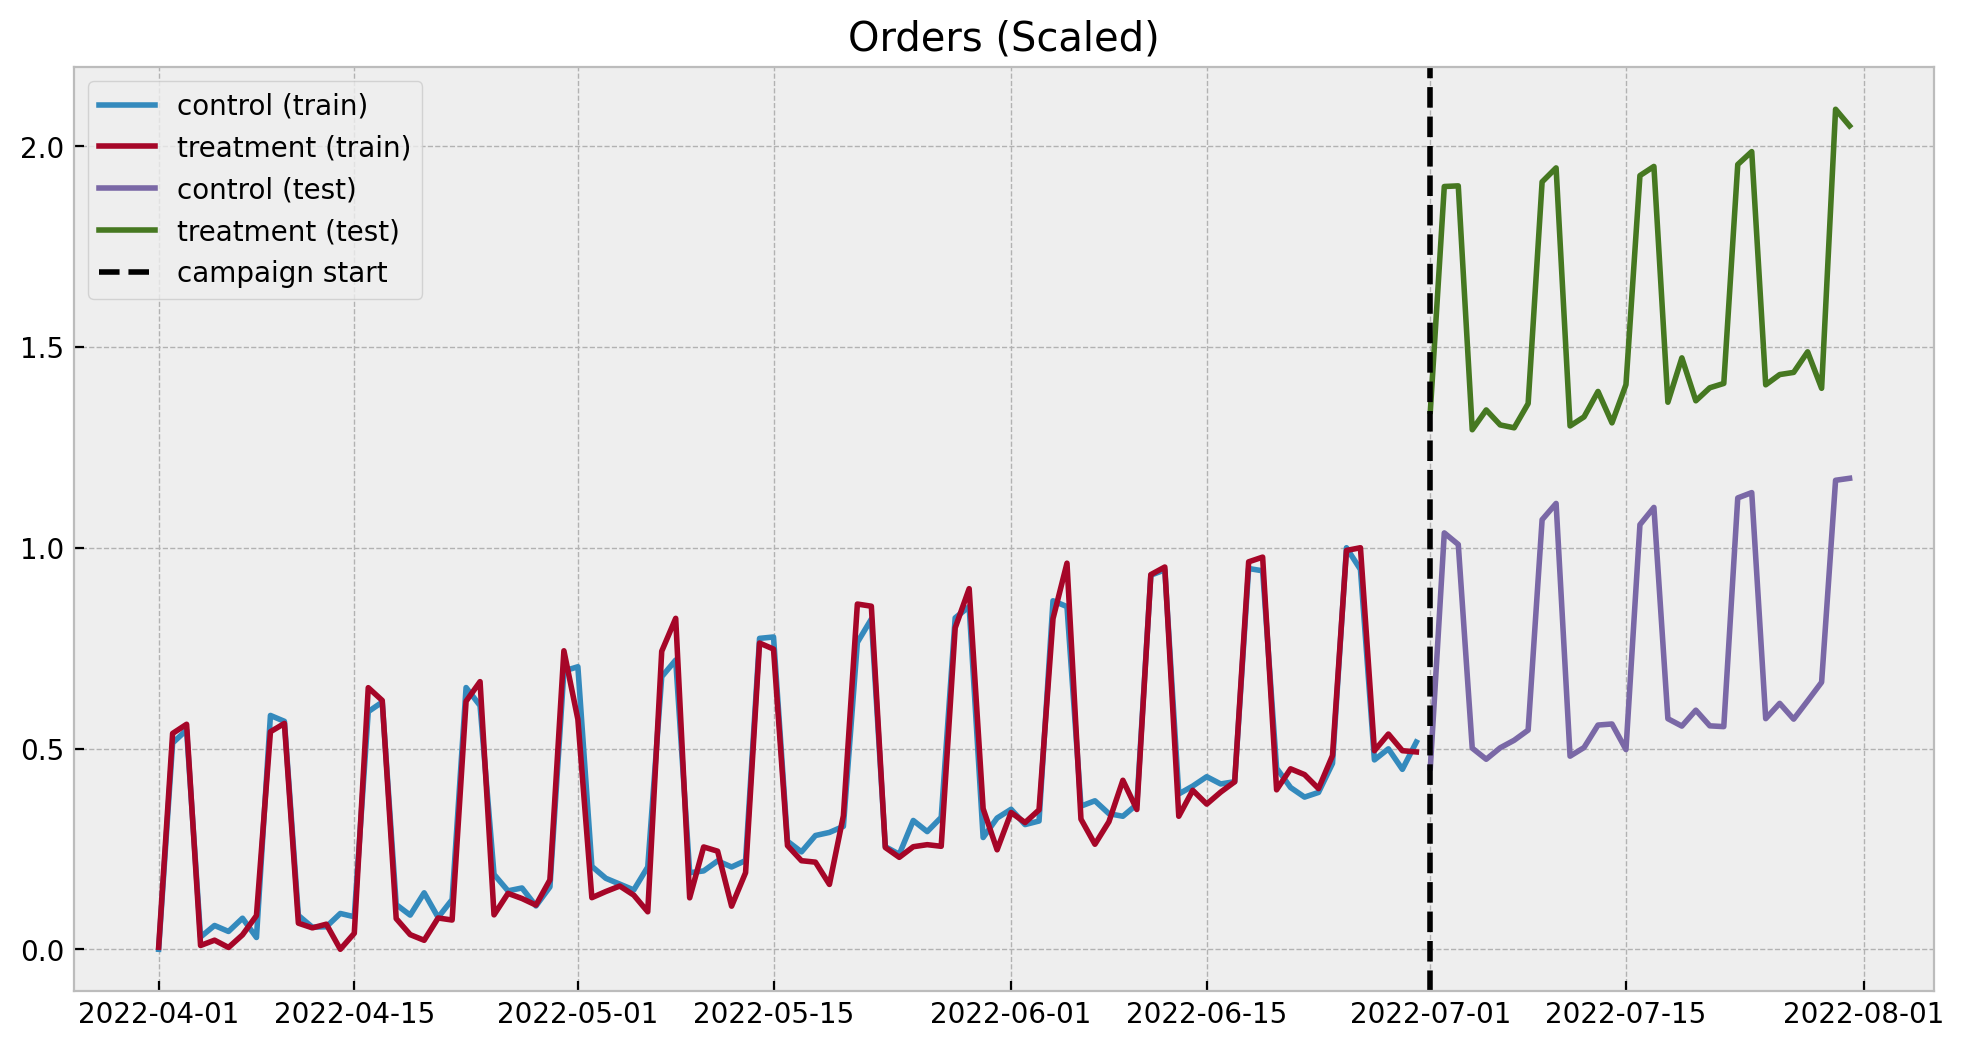

In [41]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(
    x=date_train, y=y_control_train_scaled, color="C0", label="control (train)", ax=ax
)
sns.lineplot(
    x=date_train,
    y=y_treatment_train_scaled,
    color="C1",
    label="treatment (train)",
    ax=ax,
)
sns.lineplot(
    x=date_test, y=y_control_test_scaled, color="C2", label="control (test)", ax=ax
)
sns.lineplot(
    x=date_test,
    y=y_treatment_test_scaled,
    color="C3",
    label="treatment (test)",
    ax=ax,
)
ax.axvline(x=start_campaign, color="black", linestyle="--", label="campaign start")
ax.legend(loc="upper left")
ax.set(title="Orders (Scaled)");

## Define Model

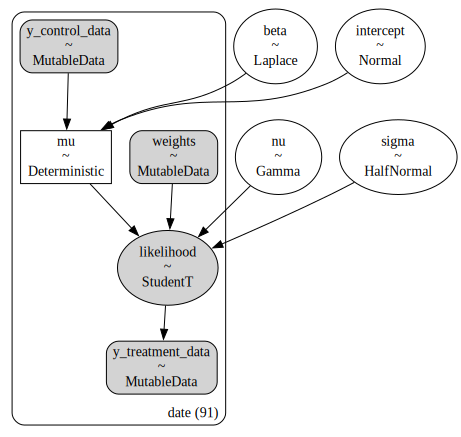

In [38]:
with pm.Model() as model:
    # --- Data Containers ---
    model.add_coord(name="date", values=date_train, mutable=True)
    y_control_data = pm.MutableData(
        name="y_control_data", value=y_control_train_scaled, dims="date"
    )
    y_treatment_data = pm.MutableData(
        name="y_treatment_data", value=y_treatment_train_scaled, dims="date"
    )
    weights = pm.MutableData(name="weights", value=w_train, dims="date")
    # --- Priors ---
    intercept = pm.Normal(name="intercept", mu=0, sigma=1)
    beta = pm.Laplace(name="beta", mu=0, b=1)
    sigma = pm.HalfNormal(name="sigma", sigma=2)
    nu = pm.Gamma(name="nu", alpha=20, beta=2)
    # --- Model Parametrization ---
    mu = pm.Deterministic(name="mu", var=intercept + beta * y_control_data, dims="date")
    sigma_weighted = sigma / weights
    # --- Likelihood ---
    likelihood = pm.StudentT(
        "likelihood", mu=mu, nu=nu, sigma=sigma_weighted, observed=y_treatment_data, dims="date"
    )

pm.model_to_graphviz(model=model)

## Prior Predictive Check

In [39]:
with model:
    prior_predictive = pm.sample_prior_predictive(samples=1000)

Sampling: [beta, intercept, likelihood, nu, sigma]
INFO:pymc:Sampling: [beta, intercept, likelihood, nu, sigma]


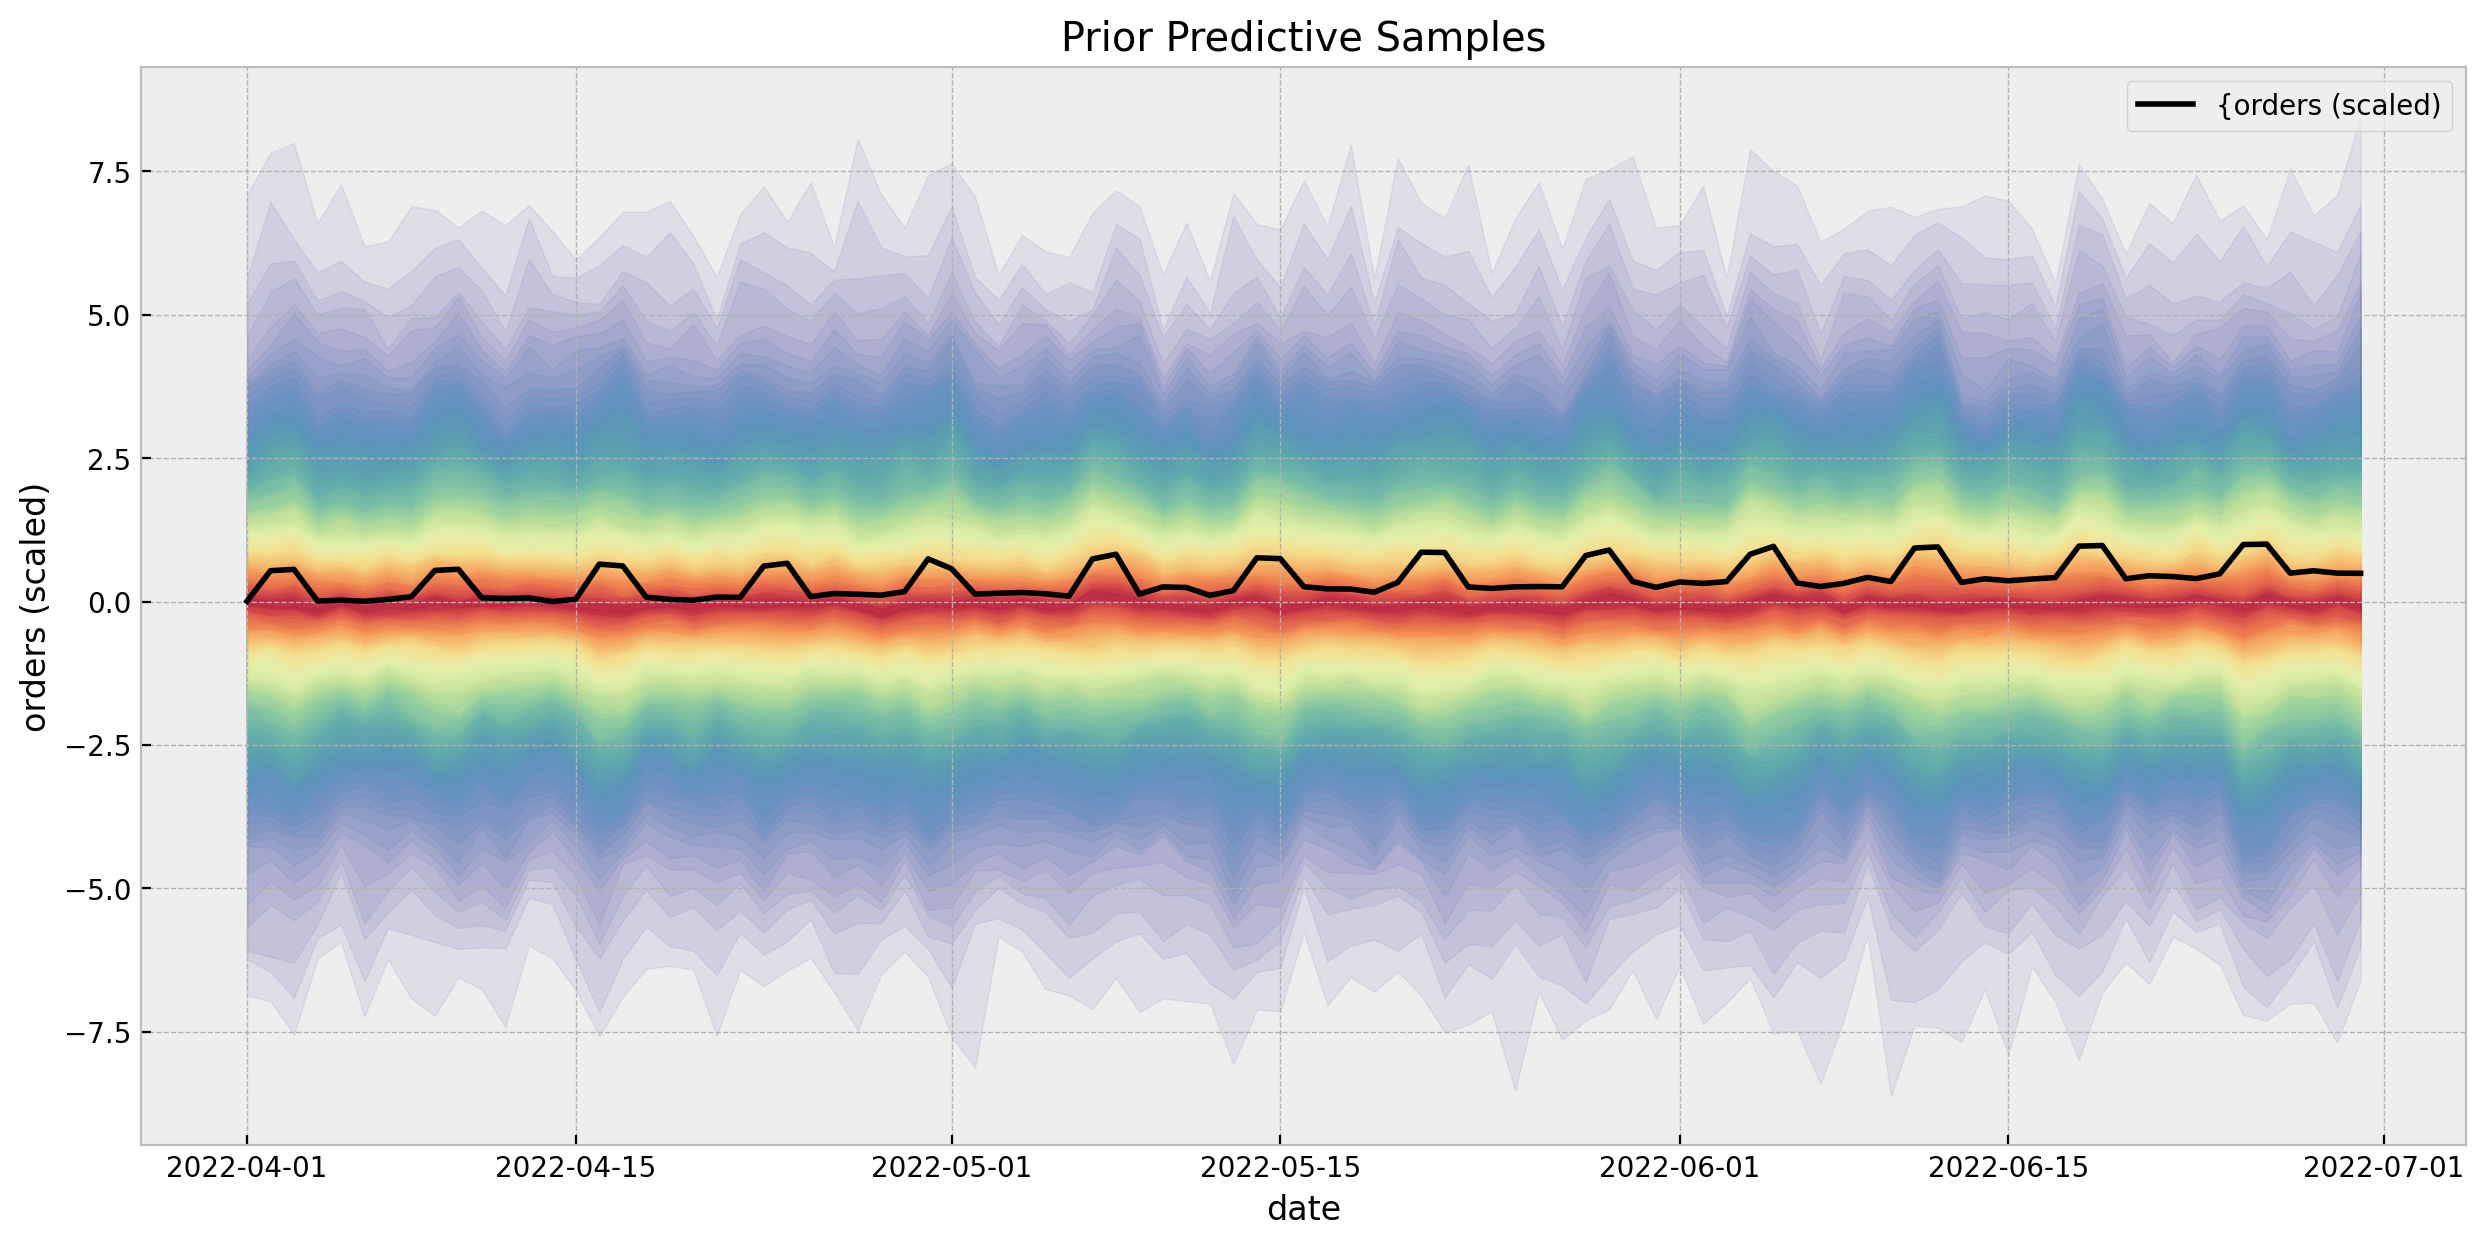

In [42]:
palette = "Spectral_r"
cmap = plt.get_cmap(palette)
percs = np.linspace(51, 99, 100)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))


fig, ax = plt.subplots(figsize=(15, 7))

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(prior_predictive.prior_predictive["likelihood"], p, axis=1)
    lower = np.percentile(
        prior_predictive.prior_predictive["likelihood"], 100 - p, axis=1
    )
    color_val = colors[i]
    ax.fill_between(
        x=date_train,
        y1=upper.flatten(),
        y2=lower.flatten(),
        color=cmap(color_val),
        alpha=0.1,
    )

sns.lineplot(
    x=date_train,
    y=y_treatment_train_scaled,
    label="{orders (scaled)",
    color="black",
    ax=ax,
)
ax.set(
    title=f"Prior Predictive Samples",
    xlabel="date",
    ylabel=f"orders (scaled)",
);

## Fit Model

In [43]:
with model:
    idata = pm.sampling_jax.sample_numpyro_nuts(draws=4000, chains=4)
    posterior_predictive = pm.sample_posterior_predictive(trace=idata)

Compiling...
Compilation time =  0:00:28.300801
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time =  0:00:04.744424
Transforming variables...
Transformation time =  0:00:00.171911
Computing Log Likelihood...


Sampling: [likelihood]
INFO:pymc:Sampling: [likelihood]


Log Likelihood time =  0:00:01.256915


## Model Diagnostics

In [44]:
var_names = [
    "intercept",
    "beta",
    "sigma",
    "nu",
]

In [45]:
az.summary(data=idata, var_names=var_names)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept  -0.035  0.009  -0.052   -0.018       0.00    0.000    7800.0   
beta        1.064  0.019   1.028    1.099       0.00    0.000    7702.0   
sigma       0.046  0.004   0.038    0.053       0.00    0.000   10518.0   
nu         10.364  2.200   6.544   14.613       0.02    0.014   12011.0   

           ess_tail  r_hat  
intercept    9401.0    1.0  
beta         9493.0    1.0  
sigma        9685.0    1.0  
nu          10570.0    1.0

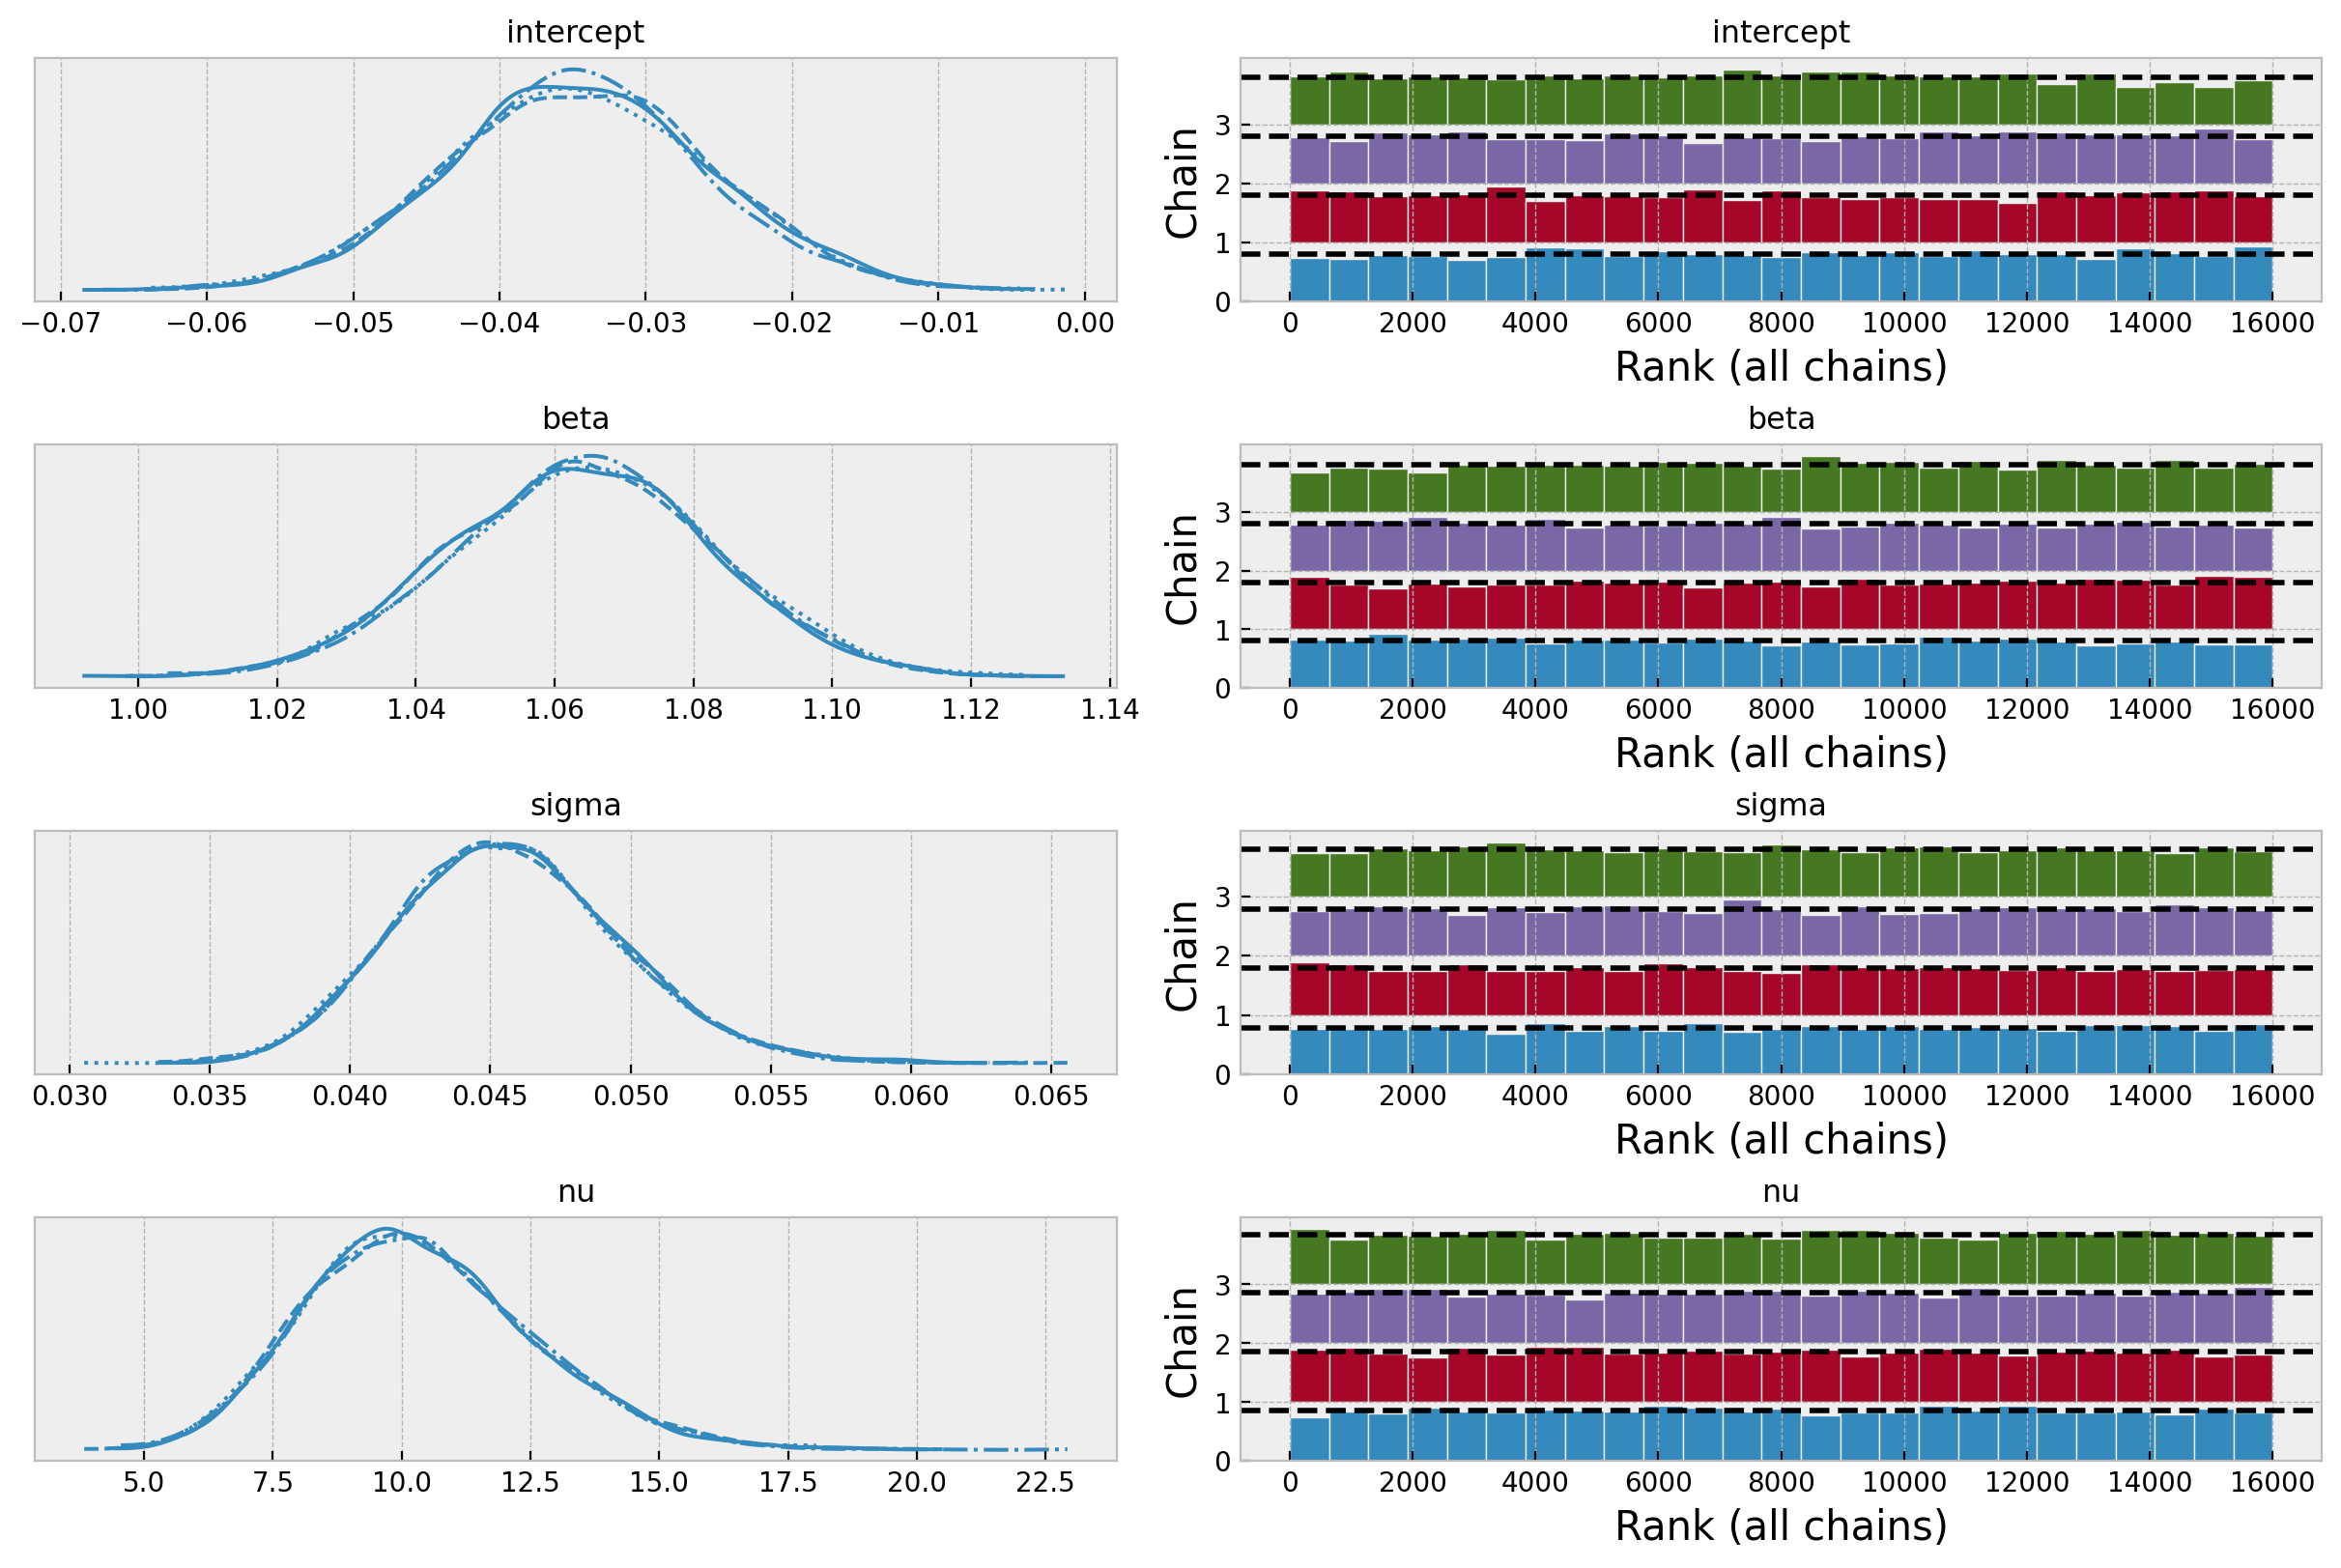

In [46]:
axes = az.plot_trace(
    data=idata,
    var_names=var_names,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 8), "layout": "constrained"},
)

## Posterior Predictive (Train)

<xarray.DataArray 'likelihood' (date: 91, sample: 16000)>
array([[-0.03243667, -0.01594029,  0.01775976, ..., -0.06793065,
         0.03303272, -0.02781143],
       [ 0.42301119,  0.44463994,  0.49719116, ...,  0.45277768,
         0.45220164,  0.49731556],
       [ 0.61563701,  0.53674194,  0.53153886, ...,  0.59494366,
         0.53090345,  0.58944653],
       ...,
       [ 0.48692253,  0.56862284,  0.49901008, ...,  0.51679091,
         0.49487814,  0.53978436],
       [ 0.42909166,  0.44190356,  0.41657423, ...,  0.42690436,
         0.45216588,  0.538507  ],
       [ 0.54257292,  0.60532554,  0.51645687, ...,  0.55573461,
         0.5548997 ,  0.52358732]])
Coordinates:
  * date     (date) datetime64[ns] 2022-04-01 2022-04-02 ... 2022-06-30
  * sample   (sample) object MultiIndex
  * chain    (sample) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int64 0 1 2 3 4 5 6 ... 3993 3994 3995 3996 3997 3998 3999

NameError: name 'metric' is not defined

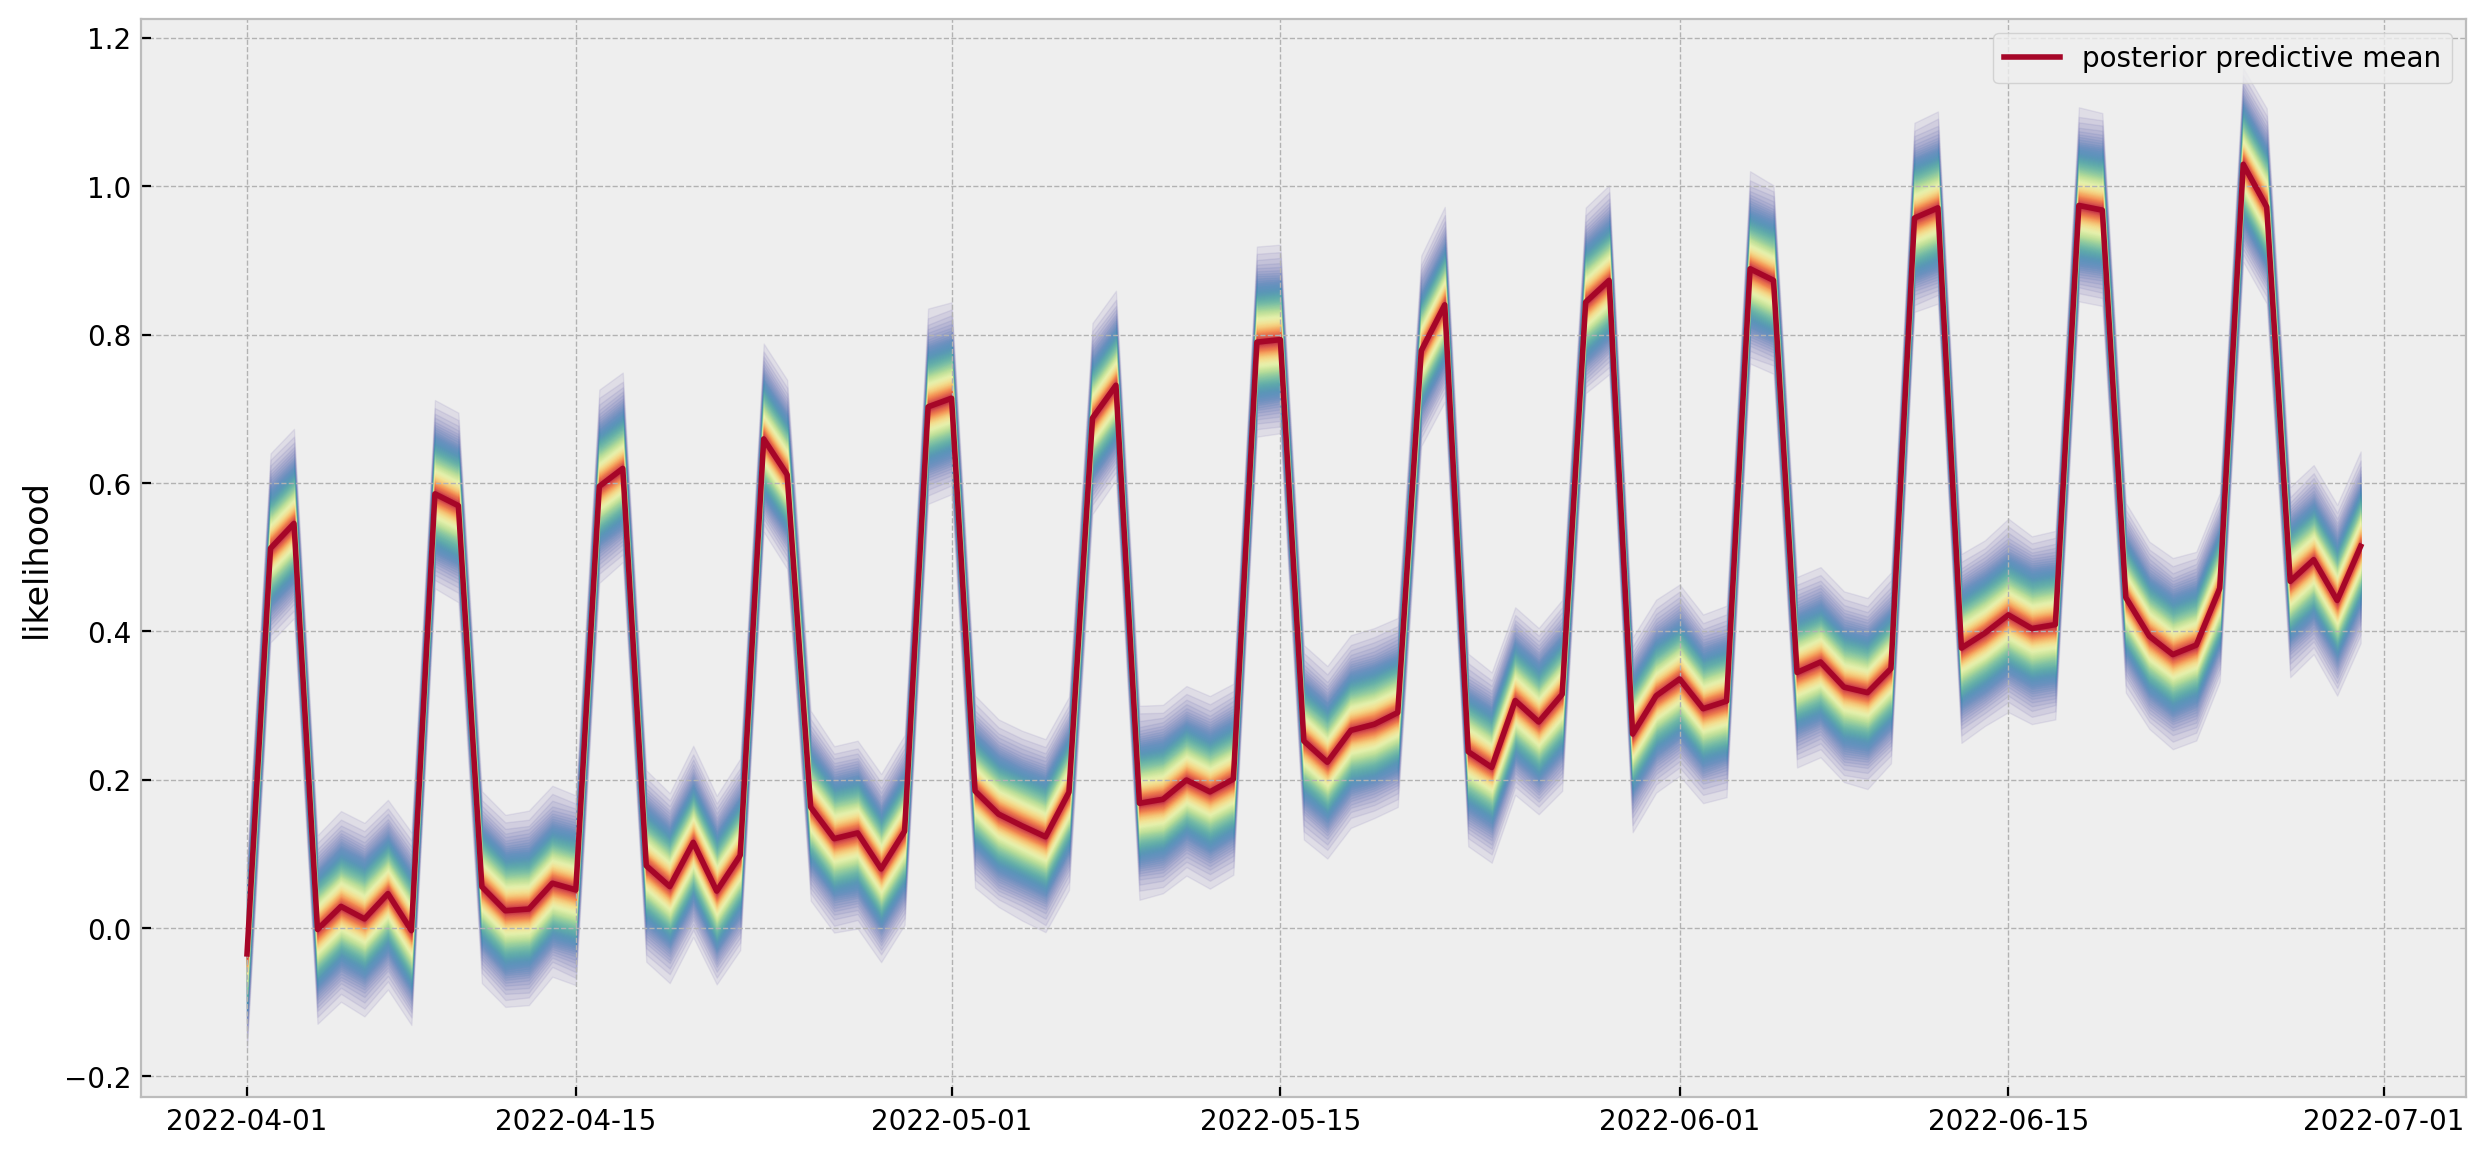

In [49]:
posterior_predictive_likelihood_train = az.extract(data=posterior_predictive, group="posterior_predictive", var_names=["likelihood"])

fig, ax = plt.subplots(figsize=(15, 7))

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(posterior_predictive_likelihood_train, p, axis=1)
    lower = np.percentile(posterior_predictive_likelihood_train, 100 - p, axis=1)
    color_val = colors[i]
    ax.fill_between(
        x=date_train,
        y1=upper,
        y2=lower,
        color=cmap(color_val),
        alpha=0.1,
    )

sns.lineplot(
    x=date_train,
    y=posterior_predictive_likelihood_train.mean(axis=1),
    color="C1",
    label="posterior predictive mean",
    ax=ax,
)
sns.lineplot(
    x=date_train,
    y=y_treatment_train_scaled,
    color="black",
    label=f"{metric} (scaled)",
    ax=ax,
)
ax.legend(loc="upper left")
ax.set(
    title=f"Posterior Predictive Samples (Train)- {metric}",
    xlabel="date",
    ylabel=f"{metric} (scaled)",
)

In [ ]:
errors_train = (
    posterior_predictive_likelihood_train - y_treatment_train_scaled[..., None]
)

errors_train_inv = (
    scaler_treatment.inverse_transform(X=posterior_predictive_likelihood_train)
    - y_treatment_train[..., None]
)

fig, ax = plt.subplots(figsize=(15, 7))
ax_twin = ax.twinx()

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(errors_train, p, axis=1)
    lower = np.percentile(errors_train, 100 - p, axis=1)
    color_val = colors[i]
    ax.fill_between(x=date_train, y1=upper, y2=lower, color=cmap(color_val), alpha=0.2)

ax.axhline(y=0, color="C1", linestyle="--")

sns.lineplot(
    x=date_train,
    y=y_treatment_train_scaled,
    color="black",
    markersize=5,
    label=f"{metric} (scaled)",
    alpha=0.4,
    ax=ax_twin,
)

ax_twin.grid(None)
ax.set(
    title="Posterior Errors Distribution (Train)",
    xlabel="date",
    ylabel=r"$\hat{y} - y$",
)

## Posterior Predictive (Test)

In [ ]:
with model:
    pm.set_data(
        new_data={
            "y_control_data": y_control_test_scaled,
            "y_treatment_data": y_treatment_test_scaled,
            "weights": w_test,
        },
        coords={"date": date_test},
    )
    idata.extend(
        pm.sample_posterior_predictive(
            trace=idata,
            var_names=["likelihood", "mu"],
            idata_kwargs={"coords": {"date": date_test}},
        )
    )

In [ ]:
posterior_predictive_likelihood_test = idata.posterior_predictive["likelihood"].stack(
    sample=("chain", "draw")
)

posterior_predictive_likelihood_test_inv = scaler_treatment.inverse_transform(
    X=posterior_predictive_likelihood_test
)

fig, ax = plt.subplots(figsize=(15, 7))

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(posterior_predictive_likelihood_test_inv, p, axis=1)
    lower = np.percentile(posterior_predictive_likelihood_test_inv, 100 - p, axis=1)
    color_val = colors[i]
    ax.fill_between(
        x=date_test,
        y1=upper,
        y2=lower,
        color=cmap(color_val),
        alpha=0.1,
    )

sns.lineplot(
    x=date_test,
    y=posterior_predictive_likelihood_test_inv.mean(axis=1),
    color="C1",
    label="posterior predictive mean",
    ax=ax,
)
sns.lineplot(
    x=date_test,
    y=y_treatment_test,
    color="black",
    label=metric,
    ax=ax,
)
ax.axvline(x=train_test_split_date, color="black", linestyle="--", label="campaign start")
ax.axvline(x=ua_off_date, color="gray", linestyle="--", label="ua decrease")
ax.legend(loc="upper left")
ax.set(
    title=f"Posterior Predictive Samples (Test) - {metric}",
    xlabel="date",
    ylabel=f"{metric}",
)

In [ ]:
errors_test_inv = y_treatment_test[..., None] - posterior_predictive_likelihood_test_inv


fig, ax = plt.subplots(figsize=(15, 7))
ax_twin = ax.twinx()

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(errors_test_inv, p, axis=1)
    lower = np.percentile(errors_test_inv, 100 - p, axis=1)
    color_val = colors[i]
    ax.fill_between(x=date_test, y1=upper, y2=lower, color=cmap(color_val), alpha=0.2)

ax.axhline(y=0, color="C1", linestyle="--")

sns.lineplot(
    x=date_test,
    y=y_treatment_test,
    color="black",
    markersize=5,
    label=metric,
    alpha=0.4,
    ax=ax_twin,
)
ax.axvline(x=train_test_split_date, color="black", linestyle="--", label="campaign start")
ax.axvline(x=ua_off_date, color="gray", linestyle="--", label="ua decrease")
ax_twin.grid(None)
ax.set(
    title=f"Posterior Errors Distribution (Test) - {metric}",
    xlabel="date",
    ylabel=r"$\hat{y} - y$",
)

In [ ]:
errors_test_cumsum = errors_test_inv.cumsum(axis=0)
errors_test_cumsum_hdi = az.hdi(ary=errors_test_cumsum.T)[-1, :]


fig, ax = plt.subplots(figsize=(15, 7))

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(errors_test_cumsum, p, axis=1)
    lower = np.percentile(errors_test_cumsum, 100 - p, axis=1)
    color_val = colors[i]
    ax.fill_between(x=date_test, y1=upper, y2=lower, color=cmap(color_val), alpha=0.2)

ax.vlines(
        x=max_date,
        ymin=errors_test_cumsum_hdi[0],
        ymax=errors_test_cumsum_hdi[1],
        color="black",
        linestyle="solid",
        linewidth=4.5,
        label="HDI (94%)",
    )

ax.axhline(y=0, color="C1", linestyle="--")
ax.axvline(x=train_test_split_date, color="black", linestyle="--", label="campaign start")
ax.axvline(x=ua_off_date, color="gray", linestyle="--", label="ua decrease")
ax.legend(loc="upper right")
ax.set(
    title=f"Posterior Errors Distribution (Test) - {metric}",
    xlabel="date",
    ylabel=r"$\hat{y} - y$",
)